# Решение ДЗ семинара 9
## Python применение продвинутых методов

Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру. Mobile Games AB Testing with Cookie Cats.

### Комментарии к набору данных:

The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:
1. userid: A unique number that identifies each player.
2. version: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
3. sum_gamerounds: the number of game rounds played by the player during the first 14 days after install.
4. retention_1: Did the player come back and play 1 day after installing?
5. retention_7: Did the player come back and play 7 days after installing?


In [52]:
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import norm, t, kstest
from statsmodels.stats.power import TTestIndPower
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

### Загрузка данных

In [53]:
df = pd.read_excel('./Cookie_Cats_AB.xlsx')

In [54]:
df.head()

userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3            0            0
1     337  gate_30              38            1            0
2     377  gate_40             165            1            0
3     483  gate_40               1            0            0
4     488  gate_40             179            1            1

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [56]:
df.describe()

userid  sum_gamerounds   retention_1   retention_7
count  9.018900e+04    90189.000000  90189.000000  90189.000000
mean   4.998412e+06       51.872457      0.445210      0.186065
std    2.883286e+06      195.050858      0.496992      0.389161
min    1.160000e+02        0.000000      0.000000      0.000000
25%    2.512230e+06        5.000000      0.000000      0.000000
50%    4.995815e+06       16.000000      0.000000      0.000000
75%    7.496452e+06       51.000000      1.000000      0.000000
max    9.999861e+06    49854.000000      1.000000      1.000000

In [57]:
# проверка на пустые значения
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [58]:
# проверим наборы данных
df.version.value_counts(), df.retention_1.value_counts(), df.retention_7.value_counts()

(gate_40    45489
 gate_30    44700
 Name: version, dtype: int64,
 0    50036
 1    40153
 Name: retention_1, dtype: int64,
 0    73408
 1    16781
 Name: retention_7, dtype: int64)

### Анализируя исходные данные, делаем предварительный вывод:

1. Пустых данных в наборе нет
2. Менять типы данных в датасете для сокращения объема и ускорения работы смысла нет
3. Данные gate_30/gate_40 разбиты примерно поровну 44700/45489 - система сплитования в первом приближении, сработала нормально.
4. Отрицательных значений в наборе нет, т.е. ошибочных значений в полях нет.
5. Поля version, retention_1, retention_7 содержит всего два значения: 'gate_30'/'gate_40' и 0/1, следовательно, в датасете результаты из двух групп, ошибочных значений в этих полях нет.

### Нормализация данных

6. Поле userid идентифицирует пользователя. Согласно правил игры, пользователю присваивается уровень gate_30 или gate_40, поэтому нужно исключить дублирование пользователей в наборе данных. Дублирующиеся userid полностью удаляются из набора.


In [59]:
# Избавимся от записей с дублирующимися userid.
df1=df.drop_duplicates(subset=['userid'])

7. Также событие retention_7 (возврат в течение недели) включает в себя событие retention_1 (возврат в течение одного дня), поэтому для дальнейшего анализа нужно отобрать записи, в которых выполняется это логическое условие

In [60]:
df=df1.query('(retention_1 == 0 and retention_7 == 0) or\
             (retention_1 == 1 and retention_7 == 0) or\
             (retention_1 == 1 and retention_7 == 1)')

In [61]:
# количество записей в очищенном наборе:
df.userid.count()

86590

In [62]:
# разделение датасетов для отображения и анализа
gate_30 = df.query('version == "gate_30"')
gate_40 = df.query('version == "gate_40"')

In [63]:
# объем выборок:
n_30=len(gate_30)
n_40=len(gate_40)
n=len(df)

games_30=gate_30.sum_gamerounds.sum()
games_40=gate_40.sum_gamerounds.sum()
games=df.sum_gamerounds.sum()

r1_30=gate_30.retention_1.sum()
r1_40=gate_40.retention_1.sum()

r7_30=gate_30.retention_7.sum()
r7_40=gate_40.retention_7.sum()

print('Абсолютный и относительный объем выборок для gate_30/gate_40:')
print(f'Юзеры {n_30/n}% ({n_30}/{n}) / {n_40/n}% ({n_40}/{n})')
print(f'Раунды игры {games_30/games}% ({games_30}/{games}) / {games_40/games}% ({games_40}/{games})')
print(f'Среднее количество раундов игры на пользователя {games_30/n_30} / {games_40/n_40}')
print(f'Возвраты за день {r1_30/n}% ({r1_30}/{n}) / {r1_40/n}% ({r1_40}/{n})')
print(f'Возвраты за неделю {r7_30/n}% ({r7_30}/{n}) / {r7_40/n}% ({r7_40}/{n})')

Абсолютный и относительный объем выборок для gate_30/gate_40:
Юзеры 0.49513800669823305% (42874/86590) / 0.504861993301767% (43716/86590)
Раунды игры 0.49556517151557294% (2161407/4361499) / 0.504434828484427% (2200092/4361499)
Среднее количество раундов игры на пользователя 50.413000886318045 / 50.32692835575075
Возвраты за день 0.23136620856911883% (20034/86590) / 0.23234784617161336% (20119/86590)
Возвраты за неделю 0.0770989721676868% (6676/86590) / 0.07513569696269777% (6506/86590)


Предполагаем, что для нас важными являются параметры: возврат пользователей и количество раундов игры.

Оценим нормальность распределения и построим гистограммы

In [64]:
# оценим нормальность распределения количества раундов в выборках
alpha = 0.05

st = shapiro(df.sum_gamerounds)
print('Шапиро: Распределение количества раундов игры {}нормальное\n'.format( {True:'не ', False:''}[st[1] < alpha]))

Шапиро: Распределение количества раундов игры не нормальное



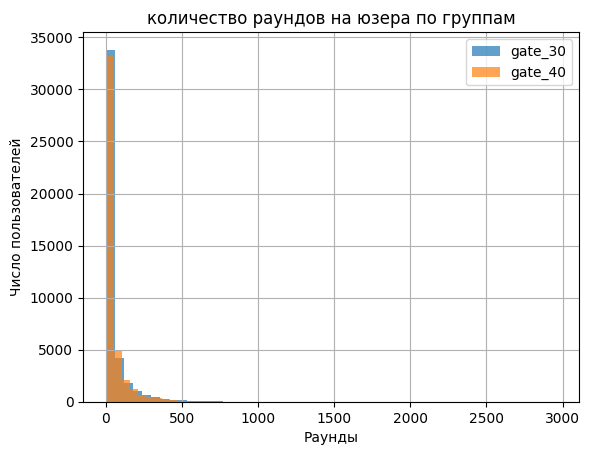

In [65]:
# строим гистограмму распределения раундов между группами gate_30 и gate_40
gate_30.sum_gamerounds.hist(bins = 50, alpha =0.7, label='gate_30')
gate_40.sum_gamerounds.hist(bins = 50, alpha =0.7, label='gate_40')
plt.title('количество раундов на юзера по группам')
plt.xlabel('Раунды')
plt.ylabel('Число пользователей')
plt.legend();

Гистограммы retention строить смысла нет. Они не показательны.

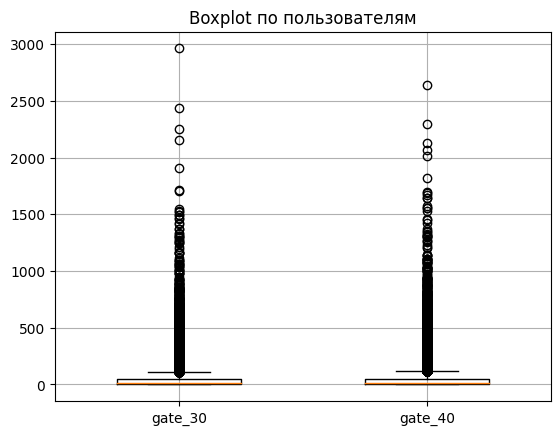

In [66]:
# строим boxplot для наборов данных: RAW и UNIC
plt.boxplot([gate_30.sum_gamerounds, gate_40.sum_gamerounds],
            labels=['gate_30', 'gate_40'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

In [67]:
import plotly.express as px # Интерактивная библиотека для графиков.
# marginal = 'box' - указываем, чтобы вывел еще и boxplot

fig = px.histogram(gate_30.sum_gamerounds, x=gate_30.sum_gamerounds, title='gate_30.sum_gamerounds', marginal = 'box')
#fig.show(renderer='colab')
fig.show()

In [68]:
fig = px.histogram(gate_40.sum_gamerounds, x=gate_40.sum_gamerounds, title='gate_40.sum_gamerounds', marginal = 'box')
fig.show()

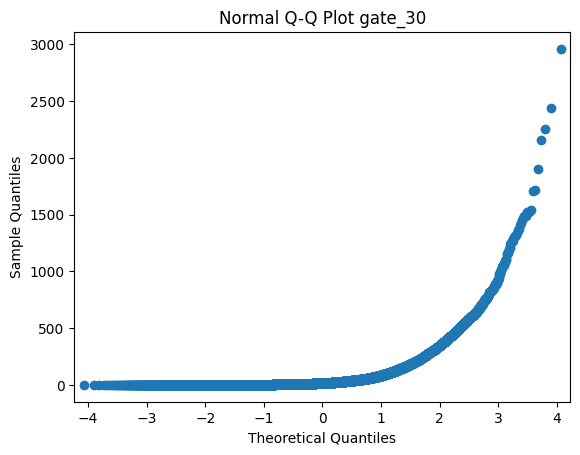

In [69]:
# QQ-plot для gate_30

fig = sm.qqplot(gate_30.sum_gamerounds)
plt.title('Normal Q-Q Plot gate_30')
plt.show;

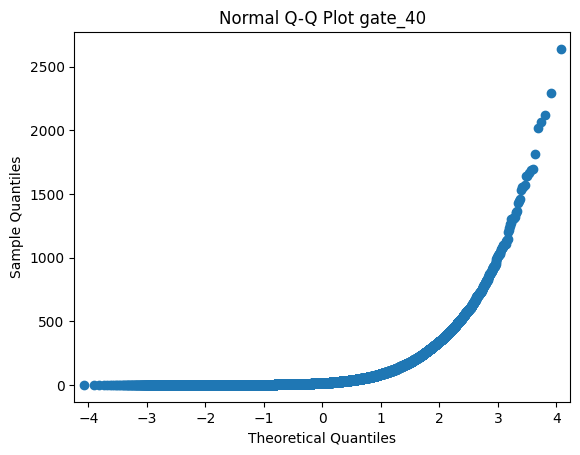

In [70]:
# QQ-plot для gate_40

fig = sm.qqplot(gate_40.sum_gamerounds)
plt.title('Normal Q-Q Plot gate_40')
plt.show;

Из графических представлений наборов данных не видно особой разницы между распределением в наборах gate_30 и в gate_40. И по внешнему виду гистограмм распределение не выглядит нормальным. На биномиальное так же не похоже.

In [71]:
# Проверим принадлежность к экспоненциальному распределению (сложная гипотеза):

print(kstest(gate_30.sum_gamerounds, 'expon'))
print(kstest(gate_40.sum_gamerounds, 'expon'))

KstestResult(statistic=0.7909089245415917, pvalue=0.0, statistic_location=3, statistic_sign=-1)
KstestResult(statistic=0.7855363830000562, pvalue=0.0, statistic_location=3, statistic_sign=-1)


Тест на экспоненциальное распределение дал отрицательный результат.

In [72]:
# оценим, есть ли статистически значимая разница в наборах
alpha = 0.05

mw = mannwhitneyu(x=gate_30.sum_gamerounds.values,
                  y=gate_40.sum_gamerounds.values)
print('Манн-Уитни: В распределениях данных количества раундов в группах gate_30 и gate_40 {}обнаружены статистически значимые отличия\n'.format( {True:'не ', False:''}[mw[1] > alpha]))


Манн-Уитни: В распределениях данных количества раундов в группах gate_30 и gate_40 не обнаружены статистически значимые отличия



### Анализ retention_1

In [73]:
# есть ли статистически значимые отличия между группами по параметру retention_1
alpha = 0.05
from statsmodels.stats import proportion
z_score, z_pvalue = proportion.proportions_ztest(np.array([r1_30, r1_40]), 
                                                   np.array([n_30, n_40]))
print('Results are ','z_score =%.3f, pvalue = %.3f'%(z_score, z_pvalue))
print('В группах gate_30 и gate_40 {}обнаружены статистически значимые отличия по retention_1\n'.format( {True:'не ', False:''}[z_pvalue > alpha]))


Results are  z_score =2.082, pvalue = 0.037
В группах gate_30 и gate_40 обнаружены статистически значимые отличия по retention_1



In [74]:
# непараметрический хи-квадрат
chisq, pvalue, table = proportion.proportions_chisquare(np.array([r1_30, r1_40]), 
                                                   np.array([n_30, n_40]))

print('Results are ','chisq =%.3f, pvalue = %.3f'%(chisq, pvalue))
print('В группах gate_30 и gate_40 {}обнаружены статистически значимые отличия по retention_1\n'.format( {True:'не ', False:''}[pvalue > alpha]))

Results are  chisq =4.333, pvalue = 0.037
В группах gate_30 и gate_40 обнаружены статистически значимые отличия по retention_1



### Анализ retention_7

In [75]:
# есть ли статистически значимые отличия между группами по параметру retention_7
alpha = 0.05
from statsmodels.stats import proportion
z_score, z_pvalue = proportion.proportions_ztest(np.array([r7_30, r7_40]), 
                                                   np.array([n_30, n_40]))
print('Results are ','z_score =%.3f, pvalue = %.3f'%(z_score, z_pvalue))
print('В группах gate_30 и gate_40 {}обнаружены статистически значимые отличия по retention_7\n'.format( {True:'не ', False:''}[z_pvalue > alpha]))


Results are  z_score =2.821, pvalue = 0.005
В группах gate_30 и gate_40 обнаружены статистически значимые отличия по retention_7



In [76]:
# непараметрический хи-квадрат
chisq, pvalue, table = proportion.proportions_chisquare(np.array([r7_30, r7_40]), 
                                                   np.array([n_30, n_40]))

print('Results are ','chisq =%.3f, pvalue = %.3f'%(chisq, pvalue))
print('В группах gate_30 и gate_40 {}обнаружены статистически значимые отличия по retention_7\n'.format( {True:'не ', False:''}[pvalue > alpha]))

Results are  chisq =7.957, pvalue = 0.005
В группах gate_30 и gate_40 обнаружены статистически значимые отличия по retention_7



z-тест и хи-квадрат показали наличие статистически значимых различий в данных по параметрам retention_1 и retention_7. Можно сделать вывод, что показатели возвращаемости игроков между версиями отличаются.

Анализ исходного набора данных RAW и почищенного от дублирующихся записей набора UNIC по критерию Манна-Уитни и Т-тест показали отсутствие статистически значимых отличий в наборах. Т.е. данные можно было не чистить.

## Расчет мощности для количества игр


d = (M1 – M2) / S_pooled

S_pooled = sqrt( (std1^2 + std2^2) /2 )

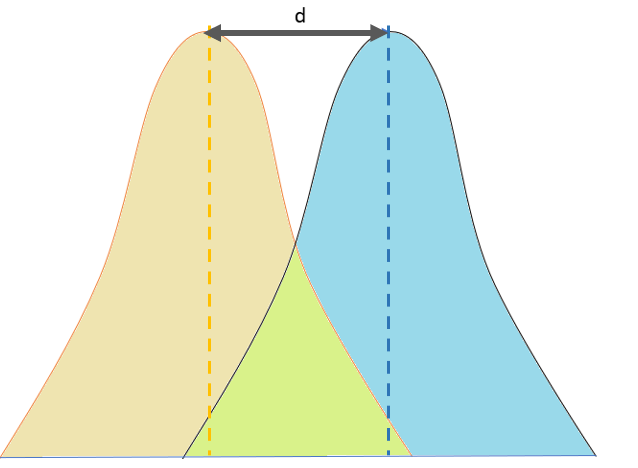

In [77]:
# расчет мощности теста
g_30_mean = gate_30.sum_gamerounds.values.mean()
g_40_mean = gate_40.sum_gamerounds.values.mean()
g_30_std = gate_30.sum_gamerounds.values.std()
g_40_std = gate_40.sum_gamerounds.values.std()
Spooled = np.sqrt((g_30_std**2 + g_40_std **2)/ 2)
effect=float((g_30_mean - g_40_mean) / Spooled)

alpha = 0.05

analysis = TTestIndPower()
power_result = analysis.solve_power(effect, power=None, nobs1=n, ratio=1.0, alpha=alpha)

effect, power_result, (g_30_mean,g_30_std), (g_40_mean,g_40_std)


(0.0008363221551181613,
 0.05347606410009599,
 (50.413000886318045, 102.31330422629928),
 (50.32692835575075, 103.51899002642743))

Мощность теста для набора данных (5.3%) очень низкая, так что для уверенного принятия решения по вопросу: какая версия gate_30 или gate_40 обеспечит большее количество игр и больший показатель retention 1 и 7, сказать сложно, т.к. мало статистических данных.

Эксперименты могли быть поставлены или проведены некорректно, или мала длительность. Тесты следует перезапустить и увеличить количество наблюдений.

bootstrap-анализ проводить смысла нет, т.к. из-за малой мощности теста его рез-ты также будут малозначимыми.

## Оценка объема выборки для нового эксперимента.

Писать код на питоне для расчета нового кол-ва испытаний лень, поэтому попробуем сделать расчет [онлайн-калькулятором](https://statulator.com/SampleSize/ss2M.html)

In [78]:
print(f'Среднее количество раундов на пользователя: {games_30/n_30}')
print(f'Хотим обнаружить 5% отклонение: {games_30/n_30*0.05}')
print(f'Стандартное отклонение: {g_30_std}')

Среднее количество раундов на пользователя: 50.413000886318045
Хотим обнаружить 5% отклонение: 2.5206500443159023
Стандартное отклонение: 102.31330422629928


Калькулятор показал, что для достоверного обнаружения эффекта нужно провести 25875 испытаний в каждой группе, итого 25875 * 2 = 51750, что меньше, чем имеющееся у нас кол-во испытаний.

Если в том же калькуляторе сделать перерасчет для 1% отклонения: 0.5041, то потребное кол-во испытаний составит 646608 на каждую группу: gate_30 и gate_40.

Возможно, низкое значение мощности теста в расчетах выше связанно с тем, что различие в среднем числе раундов между группами незначительно, поэтому результат слабый.

Рекомендация менеджеру: увеличить кол-во испытаний до 646608 * 2 = 1293216.
Данное кол-во тестов позволит кроме увеличения мощности по кол-ву игр, поднять мощность тестов по retention.